In [2]:
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob

# Define the file pattern
file_pattern = 'Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_calibration_data\\Fast_calibration_545.*_20240729_*.txt'

# Function to parse the filename
def parse_filename(filename):
    pattern = r'Fast_calibration_(\d+\.\d+)_20240729_(\d{4})\.txt'
    match = re.search(pattern, filename)
    if match:
        frequency = float(match.group(1))
        time_str = match.group(2)
        # Convert the time string to a datetime object
        time = datetime.strptime('20240729' + time_str, '%Y%m%d%H%M')
        return frequency, time
    else:
        return None, None

# Function to check if a line is a data line
def is_data_line(line):
    # A data line should be two numeric values separated by a comma
    parts = line.split(',')
    if len(parts) != 2:
        return False
    try:
        float(parts[0].strip())
        float(parts[1].strip())
        return True
    except ValueError:
        return False

# Function to read the file and extract data
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract the raw data filename from the last line
    raw_data_filename = lines[-1].strip()
    pi_times = lines[-3].strip()
    freqs = lines[-4].strip()
    
    # Extract data lines until we find a line that is not a data line
    data = []
    for line in lines:
        if is_data_line(line):
            data.append(line.strip().split(','))
        else:
            break
    
    return data, raw_data_filename, pi_times, freqs

# Get list of all matching files
file_list = glob.glob(file_pattern)

# Initialize lists to store extracted data
extracted_data = []

# Loop through each file and extract the data
for file_path in file_list:
    # Parse the filename
    filename = file_path.split('\\')[-1]
    frequency, time = parse_filename(filename)
    
    if frequency is not None and time is not None:
        # Extract data from the file
        data, raw_data_filename, pi_times, freqs = extract_data(file_path)
        
        # Store the extracted data along with frequency and time
        data_exp = [float(row[1]) for row in data]
        extracted_data.append((frequency, time, data_exp))

# Sort the extracted data by time
extracted_data.sort(key=lambda x: x[1])

# Separate the sorted data into individual lists
frequencies = [item[0] for item in extracted_data]
times = [item[1] for item in extracted_data]
all_data_exp = [item[2] for item in extracted_data]

# Output the results
print(f"Frequencies: {frequencies}")
print(f"Times: {times}")
print("Extracted Data (first few lines of each file):")
for data_exp in all_data_exp:
    print(data_exp)  # Print first few values of each file's data_exp

print(f"Number of files processed: {len(file_list)}")


Frequencies: [545.431066, 545.431066, 545.431066, 545.431066, 545.431066, 545.431066, 545.431554, 545.431554, 545.431554, 545.431554, 545.430554, 545.4307762222222, 545.4309984444444, 545.4312206666667, 545.4314428888889, 545.4316651111111, 545.4318873333333, 545.4321095555556, 545.4323317777778, 545.432554, 545.431554, 545.431289, 545.431289, 545.431315, 545.431315, 545.431315]
Times: [datetime.datetime(2024, 7, 29, 10, 45), datetime.datetime(2024, 7, 29, 10, 56), datetime.datetime(2024, 7, 29, 10, 59), datetime.datetime(2024, 7, 29, 12, 32), datetime.datetime(2024, 7, 29, 12, 38), datetime.datetime(2024, 7, 29, 12, 46), datetime.datetime(2024, 7, 29, 12, 50), datetime.datetime(2024, 7, 29, 13, 9), datetime.datetime(2024, 7, 29, 13, 21), datetime.datetime(2024, 7, 29, 13, 35), datetime.datetime(2024, 7, 29, 13, 37), datetime.datetime(2024, 7, 29, 13, 40), datetime.datetime(2024, 7, 29, 13, 44), datetime.datetime(2024, 7, 29, 13, 47), datetime.datetime(2024, 7, 29, 13, 50), datetime.da

In [4]:
print(all_data_exp[10:20])
frequencies[10:20]

[[0.16, 0.854], [0.274, 0.72], [0.344, 0.58], [0.49, 0.46], [0.598, 0.346], [0.712, 0.286], [0.818, 0.12], [0.92, 0.096], [0.95, 0.018], [0.96, 0.014]]


[545.430554,
 545.4307762222222,
 545.4309984444444,
 545.4312206666667,
 545.4314428888889,
 545.4316651111111,
 545.4318873333333,
 545.4321095555556,
 545.4323317777778,
 545.432554]

In [6]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
def unitary_product_with_ket_zero(pi_time, T, delta, t_wait_T):
    omega = np.pi / (pi_time * 1e-6)
    t_pi_over_2 = (pi_time * 1e-6) / 2

    def U1(omega, t):
        H = np.array([[0, omega / 2],
                      [omega / 2, delta]], dtype=complex)
        U = expm(-1j * H * t)
        return U

    def U_wait(omega, t):
        H = np.array([[0, 0],
                      [0, delta]], dtype=complex)
        U = expm(-1j * H * t)
        return U

    def U2(omega, t):
        H = np.array([[0, omega * np.exp(-1j * 2 * np.pi * t_wait_T) / 2],
                      [omega * np.exp(1j * 2 * np.pi * t_wait_T) / 2, delta]], dtype=complex)
        U = expm(-1j * H * t)
        return U

    U1 = U1(omega, t_pi_over_2)
    U_wait = U_wait(omega, T)
    U2 = U2(omega, t_pi_over_2)

    product = U2 @ U_wait @ U1

    ket_zero = np.array([1, 0], dtype=complex)
    result = product @ ket_zero
    state_pop = np.abs(result)**2

    # T2_star = 2.896e-3
    # decay_factor = np.exp(- T / T2_star)
    # state_pop *= decay_factor
    
    return state_pop

def call_unitary_product_twice(pi_time, T, delta):
    result1 = unitary_product_with_ket_zero(pi_time, T, delta, 1/4)
    result2 = unitary_product_with_ket_zero(pi_time, T, delta, 3/4)
    return result1[0], result2[0]

def fitting_function(delta, pi_time, T, target_results):
    computed_result1, computed_result2 = call_unitary_product_twice(pi_time, T, delta[0])
    target_result1, target_result2 = target_results
    error = (computed_result1 - target_result1)**2 + (computed_result2 - target_result2)**2
    return error

# Example usage
pi_time = 128
T = 100e-6
initial_delta_guess = [0000 * 2 * np.pi]
list_of_delta = []
list_of_uncertainty = []
for i in all_data_exp[10:20]:
    result1 = i[0]
    result2 = i[1]
    target_results = (result1 , result2) 
    print(target_results)
    result = minimize(fitting_function, initial_delta_guess, args=(pi_time, T, target_results),method='Nelder-Mead')
    optimized_delta = result.x[0]/(2*np.pi)
    list_of_delta.append(optimized_delta)

    # Estimate uncertainties in r1 and r2
    N_shots = 250
    sigma_r1 = np.sqrt(result1 * (1 - result1) / N_shots)
    sigma_r2 = np.sqrt(result2 * (1 - result2) / N_shots)

    # Wrap fitting function for reuse
    def fit_delta_for_targets(targets):
        res = minimize(fitting_function, initial_delta_guess, args=(pi_time, T, targets), method='Nelder-Mead')
        return res.x[0] / (2 * np.pi)

    # Perturb r1 up/down
    delta_r1_up = fit_delta_for_targets((result1 + sigma_r1, result2))
    delta_r1_down = fit_delta_for_targets((result1 - sigma_r1, result2))

    # Perturb r2 up/down
    delta_r2_up = fit_delta_for_targets((result1, result2 + sigma_r2))
    delta_r2_down = fit_delta_for_targets((result1, result2 - sigma_r2))

    # Estimate variance via quadrature of partial derivatives
    d_delta_dr1 = (delta_r1_up - delta_r1_down) / (2 * sigma_r1)
    d_delta_dr2 = (delta_r2_up - delta_r2_down) / (2 * sigma_r2)

    sigma_delta = np.sqrt((d_delta_dr1 * sigma_r1)**2 + (d_delta_dr2 * sigma_r2)**2)
    list_of_uncertainty.append(sigma_delta)


    # eps = np.sqrt(np.finfo(float).eps)
    # # Wrap the fitting function with fixed arguments
    # wrapped_func = lambda delta: fitting_function(delta, pi_time, T, target_results)
    
    # grad = approx_fprime(result.x, wrapped_func, epsilon=eps)

    # # Finite difference estimate of second derivative (Hessian)
    # delta_eps = 1e-6  # small perturbation
    # f1 = fitting_function([result.x[0] - delta_eps], pi_time, T, target_results)
    # f2 = fitting_function([result.x[0]], pi_time, T, target_results)
    # f3 = fitting_function([result.x[0] + delta_eps], pi_time, T, target_results)
    
    # second_derivative = (f1 - 2*f2 + f3) / (delta_eps**2)
    
    # # Estimate standard error from curvature
    # if second_derivative > 0:
    #     sigma_delta = np.sqrt(1 / second_derivative)
    # else:
    #     sigma_delta = np.nan  # bad fit or flat region
    
    # list_of_uncertainty.append(sigma_delta / (2*np.pi))  # convert to Hz


(0.16, 0.854)
(0.274, 0.72)
(0.344, 0.58)
(0.49, 0.46)
(0.598, 0.346)
(0.712, 0.286)
(0.818, 0.12)
(0.92, 0.096)
(0.95, 0.018)
(0.96, 0.014)


In [8]:
print(list_of_delta)

[-673.1123296916516, -405.5012307354156, -208.94315515410253, 26.312410332874947, 223.41475603082662, 385.99847353359024, 677.9804914606586, 850.2757341718665, 1054.2448298367017, 1090.312572776107]


In [10]:
list_of_uncertainty

[39.32253357735908,
 39.25722506219626,
 39.112916146222226,
 39.175895124556725,
 39.168622921057576,
 39.25477817640494,
 39.179906700457416,
 39.40973562395408,
 39.55203814371341,
 288.0253760237039]

In [12]:
list_of_delta = np.array(list_of_delta) - 330.7145506425697

In [14]:
ic_list_of_delta = np.linspace(-1000,1000,10)# + 330.7145506425697

-3.826880334221187


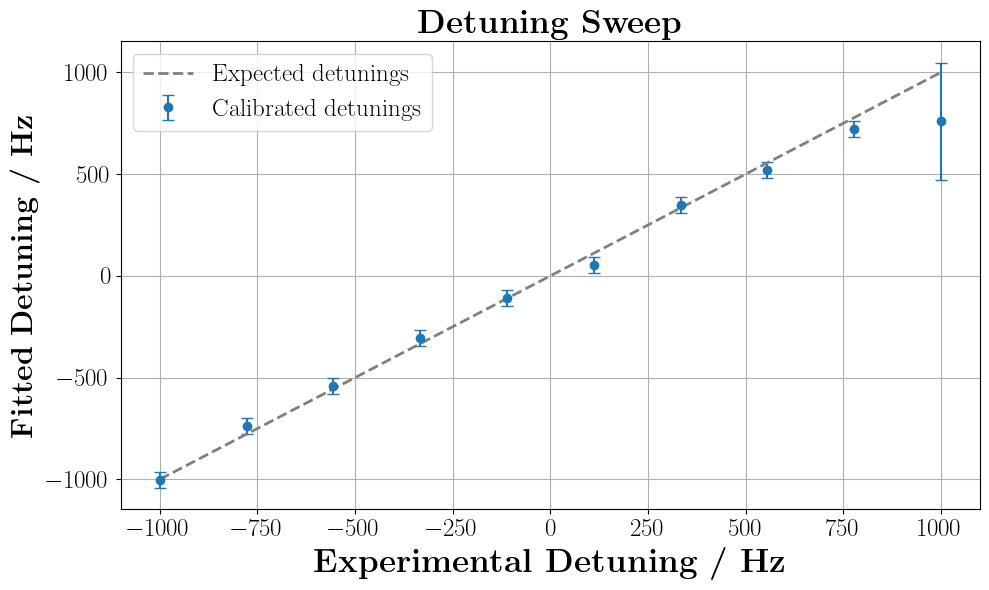

In [22]:
print(list_of_delta[0]-ic_list_of_delta[0])

from matplotlib import rcParams
import matplotlib.lines as mlines
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

# Increase font sizes
rcParams['axes.titlesize'] = 18      # Title of the plot
rcParams['axes.labelsize'] = 18      # Axis labels
rcParams['xtick.labelsize'] = 18     # X tick labels
rcParams['ytick.labelsize'] = 18     # Y tick labels
rcParams['legend.fontsize'] = 18     # Legend text
rcParams['figure.titlesize'] = 16    # Figure-wide title (if used)


plt.figure(figsize=(10,6))
plt.errorbar(ic_list_of_delta[:], list_of_delta[:],
             yerr=list_of_uncertainty[:],
             fmt='o', capsize=4, label='Calibrated detunings')

plt.plot(ic_list_of_delta[:], ic_list_of_delta[:],'--', label='Expected detunings',color='gray', linewidth  =2)
plt.xlabel(r'\textbf{Experimental Detuning / Hz}', fontsize = 24)
plt.ylabel(r'\textbf{Fitted Detuning / Hz}', fontsize = 22)
plt.title(r'\textbf{Detuning Sweep}', fontsize = 24)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('Detuning_sweep_fast_cali.svg')
plt.show()


In [97]:
np.std(list_of_delta[:-1]-ic_list_of_delta[:-1])

33.603621764709146

In [15]:
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob

import re

def extract_frequencies(freq_string):
    # Use regular expression to find numbers inside brackets
    pattern = r'\[(\d+\.\d+)\]'
    matches = re.findall(pattern, freq_string)
    
    if matches and len(matches) == 2:
        freq1 = float(matches[0])
        freq2 = float(matches[1])
        return freq1, freq2
    else:
        raise ValueError("Frequency string does not contain exactly two valid frequency values.")


# Function to parse the filename
def parse_filename(filename):
    pattern = r'Fast_calibration_(\d+p\d+)_(\d+)_20240729_(\d{4})\.txt'
    match = re.search(pattern, filename)
    if match:
        freq_str = match.group(1).replace('p', '.')
        freq = float(freq_str)
        additional_freq = int(match.group(2))
        time_str = match.group(3)
        # Convert the time string to a datetime object
        time = datetime.strptime('20240729' + time_str, '%Y%m%d%H%M')
        return (freq, additional_freq), time
    else:
        return None, None

# Function to check if a line is a data line
def is_data_line(line):
    # A data line should be two numeric values separated by a comma
    parts = line.split(',')
    if len(parts) != 2:
        return False
    try:
        float(parts[0].strip())
        float(parts[1].strip())
        return True
    except ValueError:
        return False

# Function to read the file and extract data
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract the raw data filename from the last line
    raw_data_filename = lines[-1].strip()
    
    # Extract frequency values from the same line
    freqs_line = lines[-4].strip()
    # print(type(freqs_line))
    freq1, freq2 = extract_frequencies(freqs_line)
    
    # Extract data lines until we find a line that is not a data line
    data = []
    for line in lines:
        if is_data_line(line):
            data.append(line.strip().split(','))
        else:
            break
    
    return data, raw_data_filename, (freq1, freq2)

# Define the file pattern
file_pattern = 'Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_calibration_data\\Fast_calibration_545p4321_200_20240729_*.txt'

# Get list of all matching files
file_list = glob.glob(file_pattern)

# Initialize lists to store extracted data
extracted_data = []

# Loop through each file and extract the data
for file_path in file_list:
    # Parse the filename
    filename = file_path.split('\\')[-1]
    freqs_from_name, time = parse_filename(filename)
    
    if time is not None:
        # Extract data from the file
        data, raw_data_filename, freqs_from_data = extract_data(file_path)
        
        # Store the extracted data along with time and frequencies
        data_exp = [float(row[1]) for row in data]
        extracted_data.append((time, freqs_from_name, freqs_from_data, data_exp))

# Sort the extracted data by time
extracted_data.sort(key=lambda x: x[0])

base_time = extracted_data[0][0]
times_in_seconds = [(item[0] - base_time).total_seconds() for item in extracted_data]

# Separate the sorted data into individual lists
times = [item[0] for item in extracted_data]
frequencies_from_name = [item[1] for item in extracted_data]
frequencies_from_data = [item[2] for item in extracted_data]
all_data_exp = [item[3] for item in extracted_data]

# Output the results
# print(f"Times: {times}")
# print(f"Frequencies from filename: {frequencies_from_name}")
# print(f"Frequencies from data: {frequencies_from_data}")
# print("Extracted Data (first few lines of each file):")
#for data_exp in all_data_exp:
    #print(data_exp[:5])  # Print first few values of each file's data_exp

#print(f"Number of files processed: {len(file_list)}")


In [16]:
%matplotlib widget

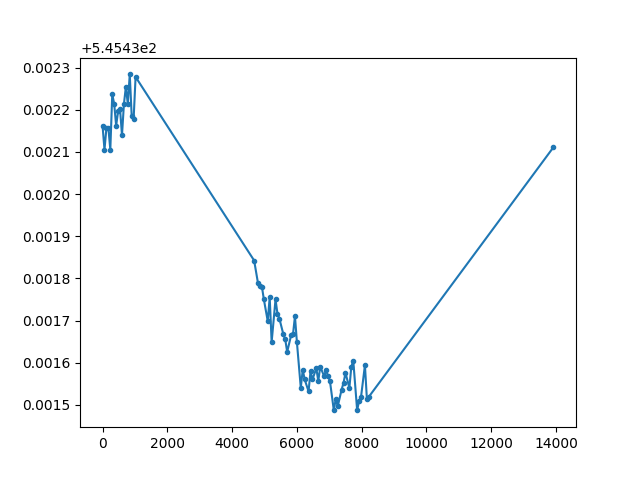

In [19]:
freq_fitted = []
for i in frequencies_from_data:
    freq_fitted.append(i[1])

plt.figure()
plt.plot(times_in_seconds,freq_fitted,'.-')
plt.show()

In [21]:
(np.array(previous_freq) - np.array(freq_fitted))*1e6

NameError: name 'previous_freq' is not defined

125
Times: [datetime.datetime(2024, 7, 30, 16, 40), datetime.datetime(2024, 7, 30, 16, 41), datetime.datetime(2024, 7, 30, 16, 42), datetime.datetime(2024, 7, 30, 16, 43), datetime.datetime(2024, 7, 30, 16, 44), datetime.datetime(2024, 7, 30, 16, 46), datetime.datetime(2024, 7, 30, 16, 47), datetime.datetime(2024, 7, 30, 16, 48), datetime.datetime(2024, 7, 30, 16, 49), datetime.datetime(2024, 7, 30, 16, 50), datetime.datetime(2024, 7, 30, 16, 52), datetime.datetime(2024, 7, 30, 16, 53), datetime.datetime(2024, 7, 30, 16, 54), datetime.datetime(2024, 7, 30, 16, 55), datetime.datetime(2024, 7, 30, 16, 56), datetime.datetime(2024, 7, 30, 16, 57), datetime.datetime(2024, 7, 30, 16, 59), datetime.datetime(2024, 7, 30, 17, 0), datetime.datetime(2024, 7, 30, 17, 1), datetime.datetime(2024, 7, 30, 17, 2), datetime.datetime(2024, 7, 30, 17, 12), datetime.datetime(2024, 7, 30, 17, 15), datetime.datetime(2024, 7, 30, 17, 18), datetime.datetime(2024, 7, 30, 17, 22), datetime.datetime(2024, 7, 30, 

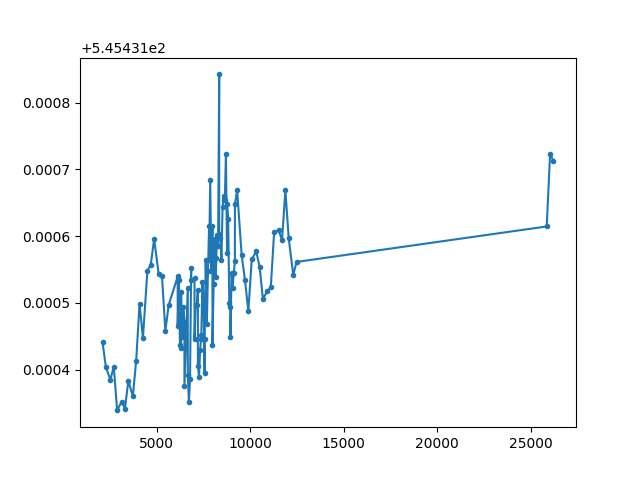

In [23]:
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob

def extract_frequencies(freq_string):
    # Use regular expression to find numbers inside brackets
    pattern = r'\[(\d+\.\d+)\]'
    matches = re.findall(pattern, freq_string)
    
    if matches and len(matches) == 2:
        freq1 = float(matches[0])
        freq2 = float(matches[1])
        return freq1, freq2
    else:
        raise ValueError("Frequency string does not contain exactly two valid frequency values.")

# Function to parse the filename
def parse_filename(filename):
    pattern = r'Fast_calibration_updating_([\d+p]+)_(\d+)_20240730_(\d{4})\.txt'
    match = re.search(pattern, filename)
    if match:
        freq_str = match.group(1).replace('p', '.')
        freq = float(freq_str)
        additional_freq = int(match.group(2))
        time_str = match.group(3)
        # Convert the time string to a datetime object
        time = datetime.strptime('20240730' + time_str, '%Y%m%d%H%M')
        return (freq, additional_freq), time
    else:
        return None, None

# Function to check if a line is a data line
def is_data_line(line):
    # A data line should be two numeric values separated by a comma
    parts = line.split(',')
    if len(parts) != 2:
        return False
    try:
        float(parts[0].strip())
        float(parts[1].strip())
        return True
    except ValueError:
        return False

# Function to read the file and extract data
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract the raw data filename from the last line
    raw_data_filename = lines[-1].strip()
    
    # Extract frequency values from the same line
    freqs_line = lines[-4].strip()
    freq1, freq2 = extract_frequencies(freqs_line)
    
    # Extract data lines until we find a line that is not a data line
    data = []
    for line in lines:
        if is_data_line(line):
            data.append(line.strip().split(','))
        else:
            break
    
    return data, raw_data_filename, (freq1, freq2)

# Define the file pattern with a wildcard for the changing part
file_pattern = 'Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_calibration_data\\Fast_calibration_updating_*_20240730_*.txt'

# Get list of all matching files
file_list = glob.glob(file_pattern)

# Initialize lists to store extracted data
extracted_data = []

# Loop through each file and extract the data
for file_path in file_list:
    # Parse the filename
    filename = file_path.split('\\')[-1]
    freqs_from_name, time = parse_filename(filename)
    
    if time is not None:
        # Extract data from the file
        data, raw_data_filename, freqs_from_data = extract_data(file_path)
        
        # Store the extracted data along with time and frequencies
        data_exp = [float(row[1]) for row in data]
        extracted_data.append((time, freqs_from_name, freqs_from_data, data_exp))

# Sort the extracted data by time
extracted_data.sort(key=lambda x: x[0])

base_time = extracted_data[0][0]
times_in_seconds = [(item[0] - base_time).total_seconds() for item in extracted_data]
print(len(times_in_seconds))
# Separate the sorted data into individual lists
times = [item[0] for item in extracted_data]
frequencies_from_name = [item[1] for item in extracted_data]
frequencies_from_data = [item[2] for item in extracted_data]
all_data_exp = [item[3] for item in extracted_data]

# Output the results
print(f"Times: {times}")
# print(f"Frequencies from filename: {frequencies_from_name}")
# print(f"Frequencies from data: {frequencies_from_data}")
# print("Extracted Data (first few lines of each file):")
# for data_exp in all_data_exp:
#     print(data_exp[:5])  # Print first few values of each file's data_exp

# print(f"Number of files processed: {len(file_list)}")
freq_fitted = []
previous_freq = []
for i in frequencies_from_data[21:]:
    freq_fitted.append(i[1])
    previous_freq.append(i[0])

plt.figure()
plt.plot(times_in_seconds[21:],freq_fitted,'.-')
print(np.diff(times_in_seconds[21:]))
plt.show()

In [25]:
%matplotlib widget

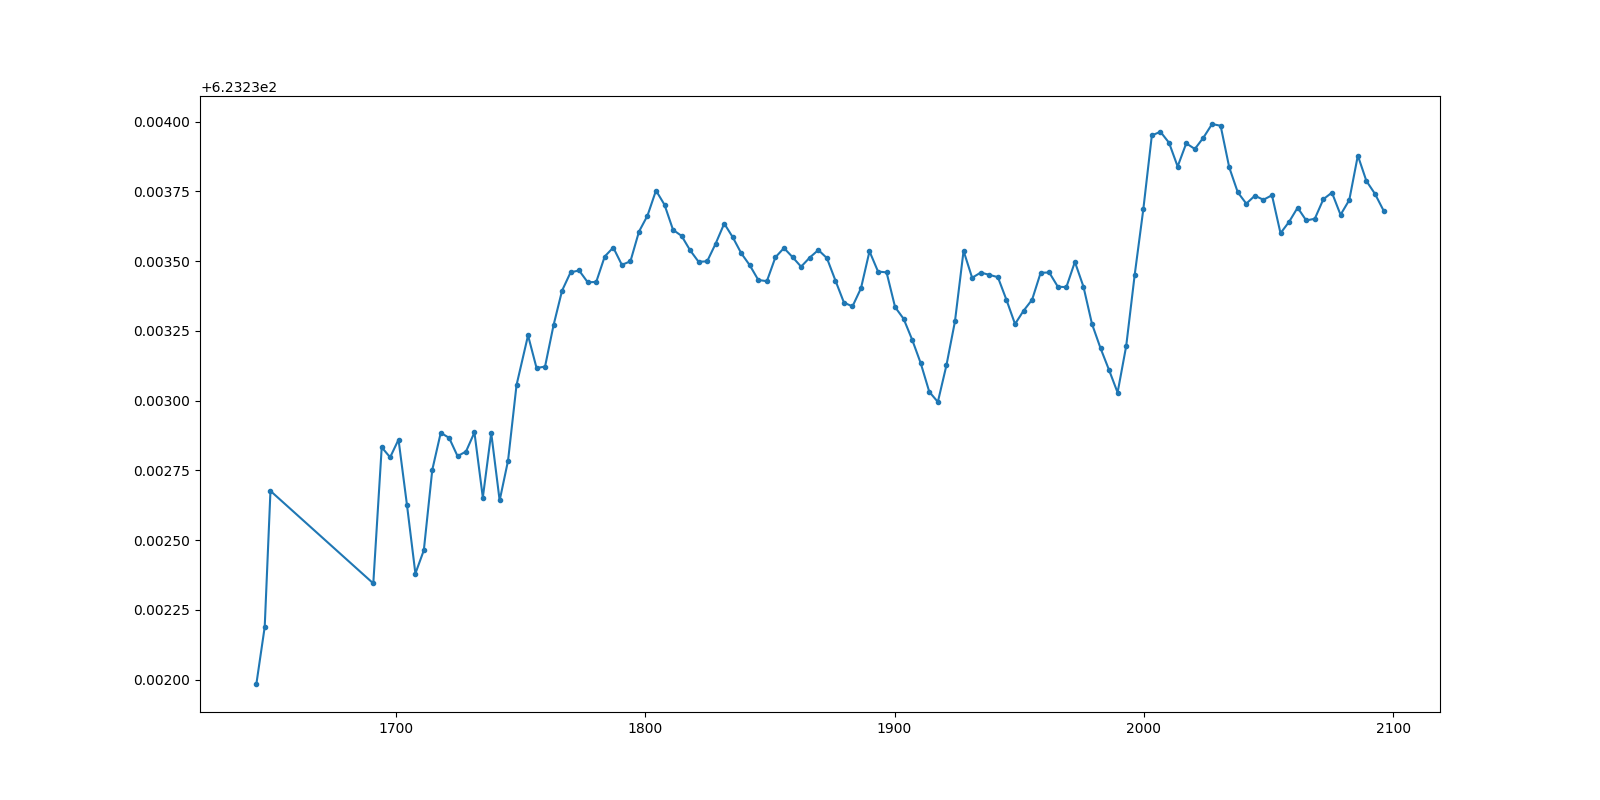

In [27]:
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def extract_frequencies(freq_string):
    # Use regular expression to find numbers inside brackets
    pattern = r'\[(\d+\.\d+)\]'
    matches = re.findall(pattern, freq_string)
    
    if matches and len(matches) == 2:
        freq1 = float(matches[0])
        freq2 = float(matches[1])
        return freq1, freq2
    else:
        raise ValueError("Frequency string does not contain exactly two valid frequency values.")

# Function to parse the filename
def parse_filename(filename):
    pattern = r'Fast_calibration_updating_([\d+p]+)_(\d+)_(\d{8})_(\d{4})\.txt'
    match = re.search(pattern, filename)
    if match:
        freq_str = match.group(1).replace('p', '.')
        freq = float(freq_str)
        additional_freq = int(match.group(2))
        return (freq, additional_freq)
    else:
        return None, None

# Function to check if a line is a data line
def is_data_line(line):
    # A data line should be two numeric values separated by a comma
    parts = line.split(',')
    if len(parts) != 2:
        return False
    try:
        float(parts[0].strip())
        float(parts[1].strip())
        return True
    except ValueError:
        return False

# Function to read the file and extract data
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract the raw data filename from the last line
    raw_data_filename = lines[-1].strip()
    
    # Extract frequency values from the same line
    freqs_line = lines[-4].strip()
    freq1, freq2 = extract_frequencies(freqs_line)
    
    # Extract data lines until we find a line that is not a data line
    data = []
    for line in lines:
        if is_data_line(line):
            data.append(line.strip().split(','))
        else:
            break
    
    return data, raw_data_filename, (freq1, freq2)

# Define the file pattern with a wildcard for the changing part
file_pattern = 'Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_calibration_data\\Fast_calibration_updating_*_*_*.txt'

# Get list of all matching files
file_list = glob.glob(file_pattern)

# Initialize lists to store extracted data
extracted_data = []

# Loop through each file and extract the data
for file_path in file_list:
    # Parse the filename
    filename = file_path.split('\\')[-1]
    freqs_from_name = parse_filename(filename)
    
    if freqs_from_name is not None:
        # Extract data from the file
        data, raw_data_filename, freqs_from_data = extract_data(file_path)
        
        # Get the file modification time
        file_mod_time = os.path.getmtime(file_path)
        time = datetime.fromtimestamp(file_mod_time)
        
        # Store the extracted data along with time and frequencies
        data_exp = [float(row[1]) for row in data]
        extracted_data.append((time, freqs_from_name, freqs_from_data, data_exp))

# Sort the extracted data by time
extracted_data.sort(key=lambda x: x[0])

base_time = extracted_data[0][0]
times_in_seconds = [(item[0] - base_time).total_seconds() for item in extracted_data]
#print(len(times_in_seconds))
# Separate the sorted data into individual lists
times = [item[0] for item in extracted_data]
frequencies_from_name = [item[1] for item in extracted_data]
frequencies_from_data = [item[2] for item in extracted_data]
all_data_exp = [item[3] for item in extracted_data]

# Output the results
#print(f"Times: {times}")
# print(f"Frequencies from filename: {frequencies_from_name}")
# print(f"Frequencies from data: {frequencies_from_data}")
# print("Extracted Data (first few lines of each file):")
# for data_exp in all_data_exp:
#     print(data_exp[:5])  # Print first few values of each file's data_exp

# print(f"Number of files processed: {len(file_list)}")
freq_fitted = []
previous_freq = []
x = -122
for i in frequencies_from_data[x:]:
    freq_fitted.append(i[1])
    previous_freq.append(i[0])

plt.figure(figsize=(16, 8))
plt.plot(np.array(times_in_seconds[x:])/60, freq_fitted, '.-')
# plt.axhline(y=0, color='r', linestyle='--')  # Plot horizontal line at y=0
#print(np.diff(times_in_seconds[21:]))
plt.show()


In [28]:
np.std(freq_fitted[-18:-2])*1e6

63.83517572184016

403
403
403
403
[1349.405169, 5810.717253, 9186.930689, 12625.183853, 30730.962996, 70464.709881, 77651.982718, 82471.927587]
nan
nan
89.87415648430859
nan
nan
56.94523295389178
17.64703479679573
nan
53.72184975971729


C:\Users\Gaurav\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Gaurav\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Gaurav\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


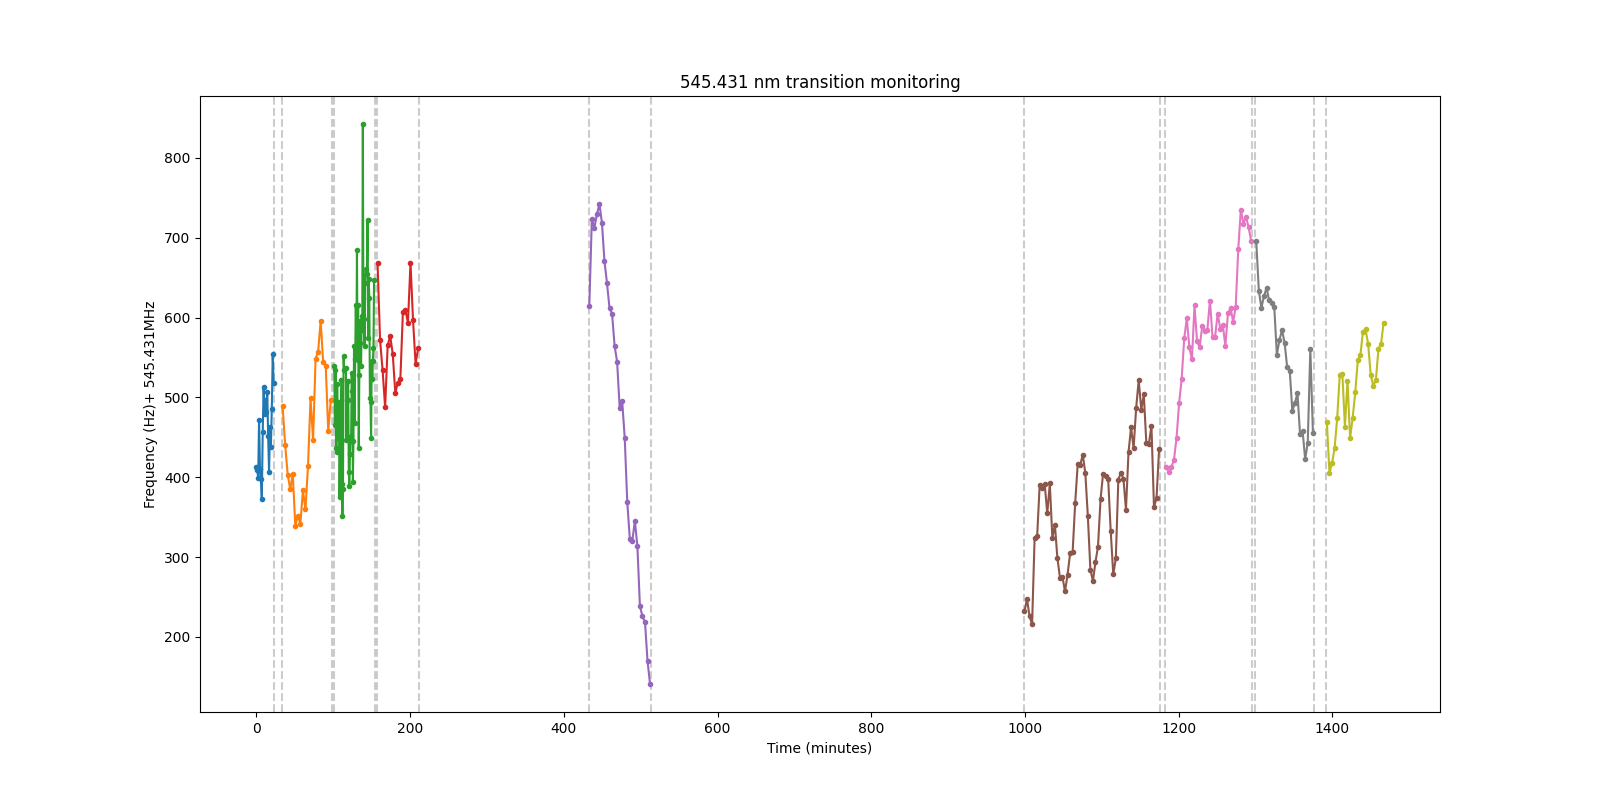

In [29]:
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def extract_frequencies(freq_string):
    pattern = r'\[(\d+\.\d+)\]'
    matches = re.findall(pattern, freq_string)
    
    if matches and len(matches) == 2:
        freq1 = float(matches[0])
        freq2 = float(matches[1])
        return freq1, freq2
    else:
        raise ValueError("Frequency string does not contain exactly two valid frequency values.")

def parse_filename(filename):
    pattern = r'Fast_calibration_updating_([\d+p]+)_(\d+)_(\d{8})_(\d{4})\.txt'
    match = re.search(pattern, filename)
    
    if match:
        freq_str = match.group(1).replace('p', '.')
        freq = float(freq_str)
        additional_freq = int(match.group(2))
        return (freq, additional_freq)
    else:
        return None, None

def is_data_line(line):
    parts = line.split(',')
    if len(parts) != 2:
        return False
    try:
        float(parts[0].strip())
        float(parts[1].strip())
        return True
    except ValueError:
        return False

def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    raw_data_filename = lines[-1].strip()
    freqs_line = lines[-4].strip()
    freq1, freq2 = extract_frequencies(freqs_line)
    
    data = []
    for line in lines:
        if is_data_line(line):
            data.append(line.strip().split(','))
        else:
            break
    
    return data, raw_data_filename, (freq1, freq2)

file_pattern = 'Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_calibration_data\\Fast_calibration_updating_*_*_*.txt'
file_list = glob.glob(file_pattern)

extracted_data = []

for file_path in file_list:
    filename = file_path.split('\\')[-1]
    freqs_from_name = parse_filename(filename)
    
    if freqs_from_name is not None:
        data, raw_data_filename, freqs_from_data = extract_data(file_path)
        file_mod_time = os.path.getmtime(file_path)
        time = datetime.fromtimestamp(file_mod_time)
        
        data_exp = [float(row[1]) for row in data]
        extracted_data.append((time, freqs_from_name, freqs_from_data, data_exp))

extracted_data.sort(key=lambda x: x[0])

base_time = extracted_data[0][0]
times_in_seconds = [(item[0] - base_time).total_seconds() for item in extracted_data]

times = [item[0] for item in extracted_data]
print(len(times))
frequencies_from_name = [item[1] for item in extracted_data]
print(len(frequencies_from_name))
frequencies_from_data = [item[2] for item in extracted_data]
print(len(frequencies_from_data))
all_data_exp = [item[3] for item in extracted_data]

time_diffs = np.diff(times_in_seconds)

freq_fitted = []
previous_freq = []
x = 0
for i in frequencies_from_data[x:]:
    freq_fitted.append(i[1])
    previous_freq.append(i[0])
print(len(freq_fitted))
# Filter frequencies and corresponding times that start with the given prefix
def filter_frequencies_and_times(frequencies, times, prefix="545"):
    filtered_freqs = []
    filtered_times = []
    for i, freq in enumerate(frequencies):
        if str(freq).startswith(prefix):
            filtered_freqs.append(freq)
            filtered_times.append(times[i])
    return filtered_freqs, filtered_times

freq = 545
filtered_freq_fitted, filtered_times = filter_frequencies_and_times(freq_fitted, times_in_seconds, prefix=str(freq))

plt.figure(figsize=(16, 8))
time_diffs = np.diff(filtered_times)

index_cutoff = np.where(time_diffs > 3.5 * 60)
cut_off_list = []
for i in index_cutoff[0]:
    cut_off_list.append(times_in_seconds[int(i)])
print(cut_off_list)

for user_time_index in index_cutoff[0]:
    plt.axvline(x=times_in_seconds[user_time_index] / 60 + 1, color='k', linestyle='--', alpha=0.2)
    plt.axvline(x=times_in_seconds[user_time_index + 1] / 60 - 1, color='k', linestyle='--', alpha=0.2)

start_time = 0
for user_time_index in index_cutoff[0]:
    plt.plot(np.array(filtered_times[start_time:user_time_index + 1]) / 60, (np.array(filtered_freq_fitted[start_time:user_time_index + 1])-np.round(filtered_freq_fitted[0],3))*1e6, '.-')
    print(np.std((np.array(filtered_freq_fitted[start_time+15:user_time_index + 1-15])-np.round(filtered_freq_fitted[0],3))*1e6))
    start_time = user_time_index + 1

plt.plot(np.array(filtered_times[start_time:]) / 60, (np.array(filtered_freq_fitted[start_time:])-np.round(filtered_freq_fitted[0],3))*1e6, '.-')
print(np.std((np.array(filtered_freq_fitted[start_time:])-np.round(filtered_freq_fitted[0],3))*1e6))
plt.xlabel('Time (minutes)')
plt.ylabel(f'Frequency (Hz)+ {np.round(filtered_freq_fitted[0],3)}MHz')
plt.title(f'{np.round(filtered_freq_fitted[0],3)} nm transition monitoring')
plt.savefig("545nm_transition_monitoring.jpg",dpi=300)
plt.show()


In [30]:
index_cutoff = np.where(time_diffs>5*60)
print(index_cutoff)
cut_off_list = []
for i in index_cutoff[0]:
    print(i)
    cut_off_list.append(times_in_seconds[int(i)])
print(cut_off_list)

(array([ 19, 121, 146, 200, 234, 257], dtype=int64),)
19
121
146
200
234
257
[1349.405169, 12625.183853, 30730.962996, 70464.709881, 77651.982718, 82471.927587]


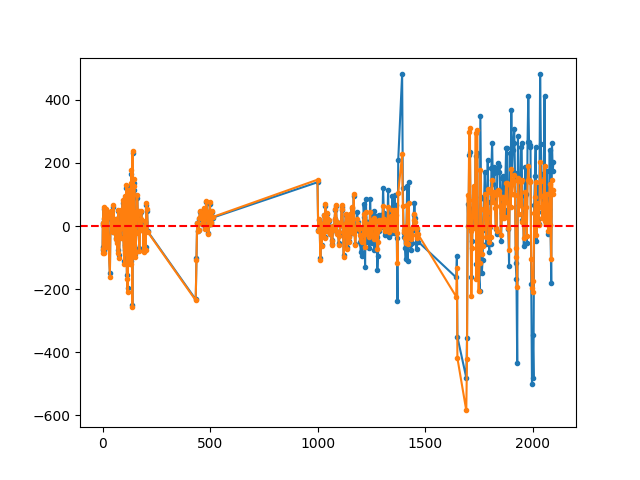

In [31]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def unitary_product_with_ket_zero(pi_time, T,T_wait, delta, t_wait_T):
    omega = np.pi / (pi_time * 1e-6)
    t_pi_over_2 = (pi_time * 1e-6) / 2

    def U1(omega, t):
        H = np.array([[0, omega / 2],
                      [omega / 2, delta]], dtype=complex)
        U = expm(-1j * H * t)
        return U

    def U_wait(omega, t):
        H = np.array([[0, 0],
                      [0, delta]], dtype=complex)
        U = expm(-1j * H * t)
        return U

    def U2(omega, t):
        H = np.array([[0, omega * np.exp(-1j * 2 * np.pi * t_wait_T) / 2],
                      [omega * np.exp(1j * 2 * np.pi * t_wait_T) / 2, delta]], dtype=complex)
        U = expm(-1j * H * t)
        return U

    U1 = U1(omega, t_pi_over_2)
    U_wait = U_wait(omega, T_wait)
    U2 = U2(omega, t_pi_over_2)

    product = U2 @ U_wait @ U1

    ket_zero = np.array([1, 0], dtype=complex)
    result = product @ ket_zero
    state_pop = np.abs(result)**2

    T2_star = 0.7e-3
    decay_factor = np.exp(- T_wait**2 / T2_star**2)
    state_pop *= decay_factor
    
    return state_pop

def call_unitary_product_twice(pi_time, T,T_wait, delta):
    result1 = unitary_product_with_ket_zero(pi_time, T,T_wait, delta, 1/4)
    result2 = unitary_product_with_ket_zero(pi_time, T,T_wait, delta, 3/4)
    return result1[0], result2[0]

def fitting_function(delta, pi_time, T,T_wait, target_results):
    computed_result1, computed_result2 = call_unitary_product_twice(pi_time, T,T_wait, delta[0])
    target_result1, target_result2 = target_results
    error = (computed_result1 - target_result1)**2 + (computed_result2 - target_result2)**2
    return error

# Example usage
pi_time = 32
T = 100e-6
T_wait= 500e-6
initial_delta_guess = [0000 * 2 * np.pi]
list_of_delta = []
for i in all_data_exp:
    result1 = i[0]
    result2 = i[1]
    target_results = (result1 , result2) 
    # print(target_results)
    result = minimize(fitting_function, initial_delta_guess, args=(pi_time, T,T_wait, target_results),method='Nelder-Mead')
    optimized_delta = result.x[0]/(2*np.pi)
    list_of_delta.append(optimized_delta)
plt.figure()
#x = 30
plt.plot(np.array(times_in_seconds[:])/60,list_of_delta[:],'.-')
plt.plot(np.array(times_in_seconds[:])/60,((np.array(previous_freq) - np.array(freq_fitted))*1e6),'.-')
plt.axhline(y=0, color='r', linestyle='--')

plt.show()

In [32]:
np.std((np.array(previous_freq) - np.array(freq_fitted))*1e6)

91.47419212067078